In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import re
from googletrans import Translator, LANGUAGES

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(1)

In [5]:
def plot_data(label_count):
    # Plot configuration
    x = np.arange(0,12)

    fig, ax = plt.subplots(figsize=(15, 6))

    rects = ax.bar(x, label_count.values())
    ax.bar_label(rects, padding=4)

    # Customization
    ax.set_xlabel('Categories')
    ax.set_ylabel('Counts')
    ax.set_title('HSD')
    ax.set_xticks(x)
    ax.set_xticklabels(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
        'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
        'HS_Strong'])

    # Show the chart
    plt.show()

In [6]:
def count_label_occurences(df, labels, subclasses=None):
    if subclasses:
        count = {label: {subclass: 0 for subclass in subclasses} for label in labels}
    else:
        count = {label: 0 for label in labels}

    for i in range(df.shape[0]):
        data = df.iloc[i]
        for label in labels:
            if subclasses:
                count[label][data[label]] += 1
            elif data[label] == 1:
                count[label] += 1

    return count

In [7]:
def verify_imbalance_ratio(y):
    """
    Verify and print the imbalance ratio for each label
    
    args
    y: pandas.DataFrame, target vector dataframe
    
    return
    imbalance_ratios: dict, imbalance ratio for each label
    mean_ratio: float, mean imbalance ratio across all labels
    """
    print("Imbalance ratios:")
    imbalance_ratios = {}
    finite_ratios = []
    
    for col in y.columns:
        counts = y[col].value_counts()
        # If the label has both 0 and 1
        if 0 in counts.index and 1 in counts.index:
            ratio = counts[0] / counts[1]
            imbalance_ratios[col] = ratio
            finite_ratios.append(ratio)
            print(f"{col}: {ratio:.2f}")
        else:
            if 1 not in counts.index:
                print(f"{col}: No minority samples (ratio = inf)")
                imbalance_ratios[col] = np.inf
            else:
                print(f"{col}: No majority samples (ratio = 0)")
                imbalance_ratios[col] = 0
                finite_ratios.append(0)
    
    # Calculate mean of finite ratios
    if finite_ratios:
        mean_ratio = np.mean(finite_ratios)
        print(f"Mean imbalance ratio: {mean_ratio:.2f}")
    else:
        mean_ratio = np.inf
        print("Mean imbalance ratio: inf (no finite ratios)")
    
    return imbalance_ratios, mean_ratio

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')
{'HS': 5561, 'Abusive': 5043, 'HS_Individual': 3575, 'HS_Group': 1986, 'HS_Religion': 793, 'HS_Race': 566, 'HS_Physical': 323, 'HS_Gender': 306, 'HS_Other': 3740, 'HS_Weak': 3383, 'HS_Moderate': 1705, 'HS_Strong': 473}


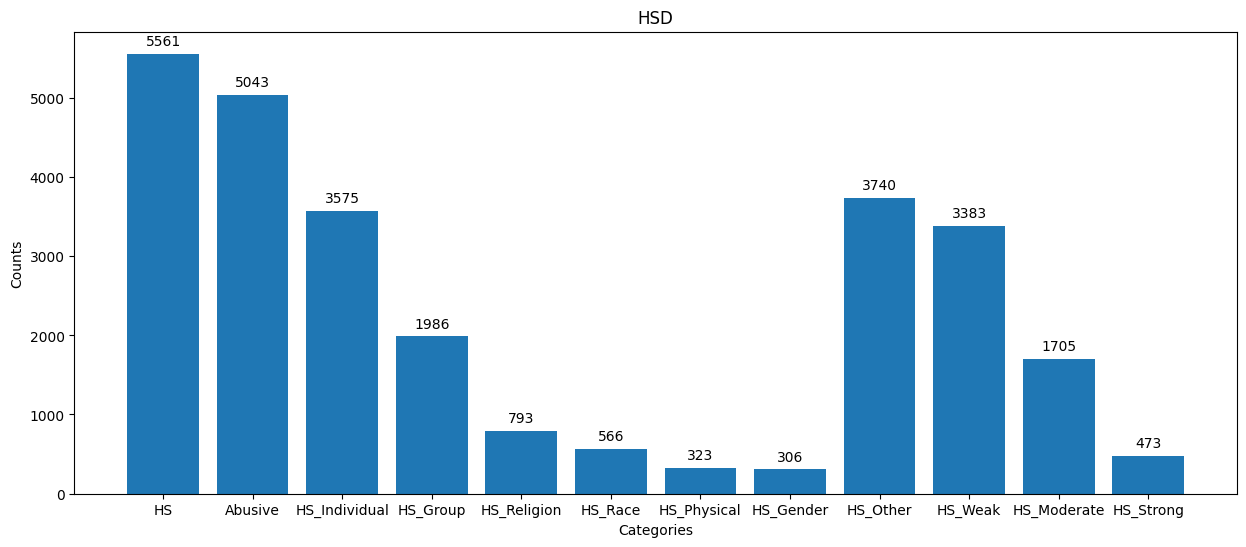

In [8]:
data = pd.read_csv('../re_dataset.csv', encoding='latin-1')
alay_dict = pd.read_csv('../new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})
X = data["Tweet"]
y = data[data.columns[1:]]

label_columns = data.columns[1:]
print(label_columns)

label_count = count_label_occurences(data, label_columns)
print(label_count)

plot_data(label_count)

In [9]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [10]:
async def back_translate_async(texts, target_lang='en', original_lang='id'):
    """
    Performs back-translation for batch of texts.
    """

    preprocessed_texts = [preprocess(text) for text in texts]
    async with Translator() as translator:
        translated_obj = await translator.translate(preprocessed_texts, dest=target_lang, src=original_lang)
        translated_text = [trans.text for trans in translated_obj]

        back_translated_obj = await translator.translate(translated_text, dest=original_lang, src=target_lang)
        return [trans.text.lower().strip() for trans in back_translated_obj]

# Undersampling

In [25]:
data = pd.read_csv('../re_dataset.csv', encoding='latin-1')
print("Before:", data.shape)

Before: (13169, 13)


In [26]:
# Downsample HS_Other
other_mask = (
    (data['HS_Other'] == 1) &
    (data['HS_Individual'] == 1)
)
other = data[other_mask]
print("Other:", other.shape)
other_sampled = other.sample(n=75, random_state=42)
non_other = data[~other_mask]
data = pd.concat([non_other, other_sampled], axis=0).reset_index(drop=True)

Other: (2699, 13)


In [27]:
# Downsample HS_Other
other_mask = (
    (data['HS_Other'] == 1) &
    (data['HS_Individual'] == 0)
)
other = data[other_mask]
print("Other:", other.shape)
other_sampled = other.sample(n=231, random_state=42)
non_other = data[~other_mask]
data = pd.concat([non_other, other_sampled], axis=0).reset_index(drop=True)

Other: (1041, 13)


In [28]:
religion_mask = (
    (data['HS_Religion'] == 1) &
    (data['HS_Individual'] == 0)
)
religion = data[religion_mask]
print("Religion:", religion.shape)
religion_sampled = religion.sample(n=206, random_state=42)
non_religion = data[~religion_mask]
data = pd.concat([non_religion, religion_sampled], axis=0).reset_index(drop=True)

Religion: (528, 13)


In [29]:
religion_mask = (
    (data['HS_Religion'] == 1) &
    (data['HS_Individual'] == 1)
)
religion = data[religion_mask]
print("Religion:", religion.shape)
religion_sampled = religion.sample(n=100, random_state=42)
non_religion = data[~religion_mask]
data = pd.concat([non_religion, religion_sampled], axis=0).reset_index(drop=True)

Religion: (265, 13)


In [30]:
race_mask = (
    (data['HS_Race'] == 1)
)
race = data[race_mask]
race_sampled = race.sample(n=306, random_state=42)
non_race = data[~race_mask]
data = pd.concat([non_race, race_sampled], axis=0).reset_index(drop=True)

In [31]:
abusive_mask = (
    (data['Abusive'] == 1) & 
    (data['HS'] == 0)
)
abusive = data[abusive_mask]
print(abusive.shape)
abusive_sampled = abusive.sample(n=442, random_state=42)
non_abusive = data[~abusive_mask]
data = pd.concat([non_abusive, abusive_sampled], axis=0).reset_index(drop=True)

(1748, 13)


In [32]:
hs_mask = (
    (data['Abusive'] == 0) & 
    (data['HS'] == 0)
)
hs = data[hs_mask]
print(hs.shape)
hs_sampled = hs.sample(n=1440, random_state=42)
non_hs = data[~hs_mask]
data = pd.concat([non_hs, hs_sampled], axis=0).reset_index(drop=True)

(5860, 13)


After: (3328, 13)
{'HS': 1446, 'Abusive': 1446, 'HS_Individual': 734, 'HS_Group': 712, 'HS_Religion': 295, 'HS_Race': 306, 'HS_Physical': 312, 'HS_Gender': 288, 'HS_Other': 306, 'HS_Weak': 716, 'HS_Moderate': 609, 'HS_Strong': 121}
Imbalance ratios:
HS: 1.30
Abusive: 1.30
HS_Individual: 3.53
HS_Group: 3.67
HS_Religion: 10.28
HS_Race: 9.88
HS_Physical: 9.67
HS_Gender: 10.56
HS_Other: 9.88
HS_Weak: 3.65
HS_Moderate: 4.46
HS_Strong: 26.50
Mean imbalance ratio: 7.89
({'HS': 1.301521438450899, 'Abusive': 1.301521438450899, 'HS_Individual': 3.534059945504087, 'HS_Group': 3.6741573033707864, 'HS_Religion': 10.28135593220339, 'HS_Race': 9.875816993464053, 'HS_Physical': 9.666666666666666, 'HS_Gender': 10.555555555555555, 'HS_Other': 9.875816993464053, 'HS_Weak': 3.64804469273743, 'HS_Moderate': 4.464696223316913, 'HS_Strong': 26.50413223140496}, 7.8902787845491416)


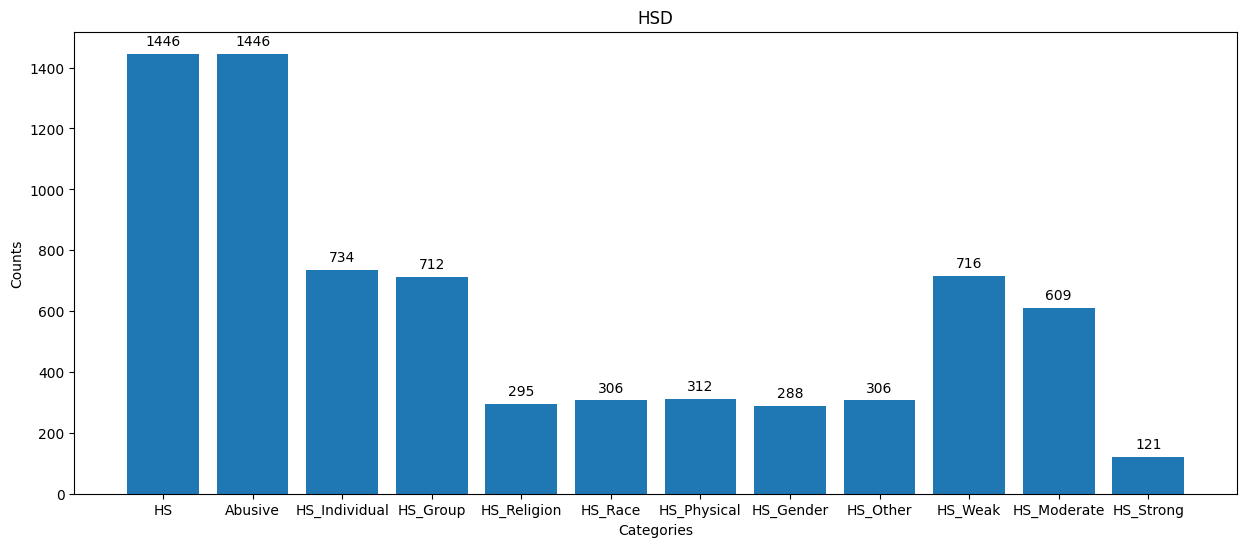

In [33]:
print("After:", data.shape)
label_columns = data.columns[1:]

aug_label_count = count_label_occurences(data, label_columns)
print(aug_label_count)

y = data[data.columns[1:]]
print(verify_imbalance_ratio(y))

plot_data(aug_label_count)

In [34]:
data.to_csv('./undersampled.csv', index=False, encoding='latin-1')

# Oversampling

Before: (13169, 13)
Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')
{'HS': 5561, 'Abusive': 5043, 'HS_Individual': 3575, 'HS_Group': 1986, 'HS_Religion': 793, 'HS_Race': 566, 'HS_Physical': 323, 'HS_Gender': 306, 'HS_Other': 3740, 'HS_Weak': 3383, 'HS_Moderate': 1705, 'HS_Strong': 473}


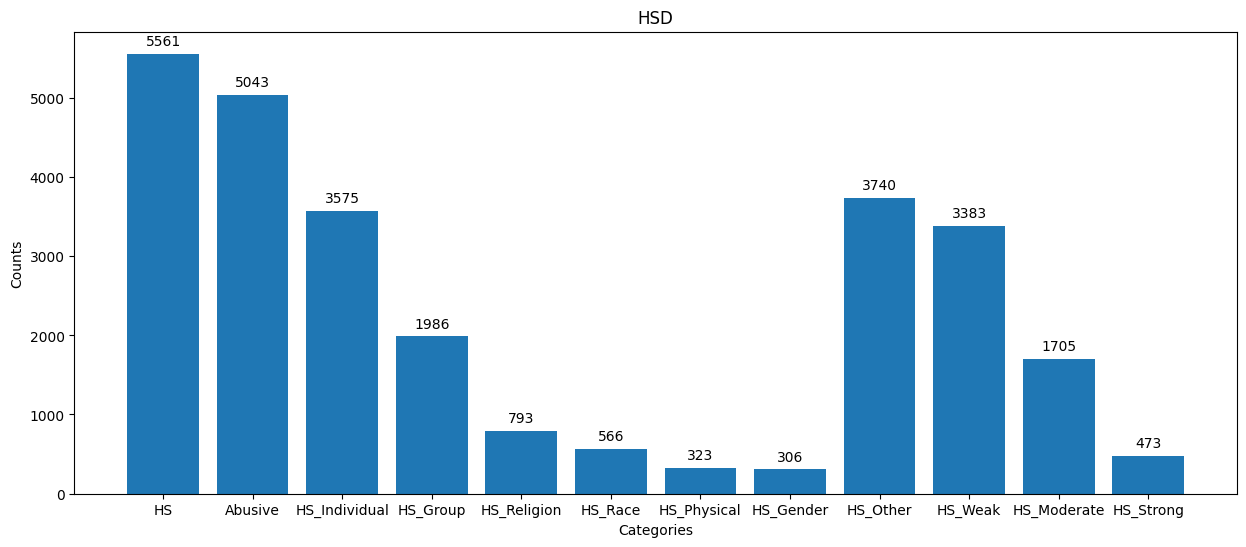

In [14]:
data = pd.read_csv('../re_dataset.csv', encoding='latin-1')
print("Before:", data.shape)

label_columns = data.columns[1:]
print(label_columns)

label_count = count_label_occurences(data, label_columns)
print(label_count)

plot_data(label_count)

In [15]:
# Downsample HS_Other
other_mask = (
    (data['HS_Other'] == 1)
)
other = data[other_mask]
other_sampled = other.sample(n=1300, random_state=42)
non_other = data[~other_mask]
data = pd.concat([non_other, other_sampled], axis=0).reset_index(drop=True)

In [16]:
# Augmenting HS_Religion
print("Augmenting HS_Religion with Moderate Severity")
religion = data[(data['HS_Religion'] == 1) & (data['HS_Group'] == 1) & (data['HS_Moderate'] == 1)]
print(religion.shape)
religion = religion.sample(350, random_state=42)
translated = await back_translate_async(religion["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    religion["Tweet"].values[i] = translated[i]

Augmenting HS_Religion with Moderate Severity
(464, 13)


In [17]:
print("Augmenting HS_Race with Moderate Severity")
race = data[(data['HS_Race'] == 1) & (data['HS_Group'] == 1) & (data['HS_Moderate'] == 1)]
print(race.shape)
# race = race.sample(n=100, random_state=42)
translated = await back_translate_async(race["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    race["Tweet"].values[i] = translated[i]

Augmenting HS_Race with Moderate Severity
(288, 13)


In [18]:
print("Augmenting HS_Race with Strong Severity")
race_strong = data[(data['HS_Race'] == 1) & (data['HS_Group'] == 1) & (data['HS_Strong'] == 1)]
print(race_strong.shape)
translated = await back_translate_async(race_strong["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    race_strong["Tweet"].values[i] = translated[i]

Augmenting HS_Race with Strong Severity
(125, 13)


In [19]:
print("Augmenting HS_Physical with Weak Severity")
physical = data[
    (data['HS_Physical'] == 1) & 
    (data['Abusive'] == 1) & 
    (data['HS_Weak'] == 1) &
    (data['HS_Individual'] == 1)
]
print(physical.shape)
translated = await back_translate_async(physical["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    physical["Tweet"].values[i] = translated[i]

Augmenting HS_Physical with Weak Severity
(274, 13)


In [20]:
print("Augmenting HS_Physical with Moderate Severity")
physical_moderate = data[
    (data['HS_Physical'] == 1) & 
    (data['HS_Group'] == 1) & 
    (data['HS_Moderate'] == 1)
]
print(physical_moderate.shape)
translated = await back_translate_async(physical_moderate["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    physical_moderate["Tweet"].values[i] = translated[i]

Augmenting HS_Physical with Moderate Severity
(42, 13)


In [21]:
print("Augmenting HS_Gender with Weak Severity")
gender_weak = data[
    (data['HS_Gender'] == 1) & 
    (data['Abusive'] == 1) & 
    (data['HS_Weak'] == 1)
]
print(gender_weak.shape)
translated = await back_translate_async(gender_weak["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    gender_weak["Tweet"].values[i] = translated[i]

Augmenting HS_Gender with Weak Severity
(237, 13)


In [22]:
phys_mod = data[
    (data['HS_Physical'] == 1) & 
    (data['HS_Group'] == 1) & 
    (data['HS_Moderate'] == 1)
]
gen_weak = data[
    (data['HS_Gender'] == 1) & 
    (data['Abusive'] == 1) & 
    (data['HS_Weak'] == 1)
]

for i in range(3):
    if i < 2:
        data = pd.concat([data, gen_weak], axis=0).reset_index(drop=True)
    data = pd.concat([data, phys_mod], axis=0).reset_index(drop=True)

In [ ]:
data = pd.concat([data, religion], axis=0).reset_index(drop=True)
data = pd.concat([data, race], axis=0).reset_index(drop=True)
    
for i in range(4):
    if i < 2:
        data = pd.concat([data, physical], axis=0).reset_index(drop=True)
        data = pd.concat([data, gender_weak], axis=0).reset_index(drop=True)
    if i < 3:
        data = pd.concat([data, race_strong], axis=0).reset_index(drop=True)
    data = pd.concat([data, physical_moderate], axis=0).reset_index(drop=True)

After: (13532, 13)
{'HS': 5924, 'Abusive': 5733, 'HS_Individual': 3312, 'HS_Group': 2612, 'HS_Religion': 1353, 'HS_Race': 1281, 'HS_Physical': 1259, 'HS_Gender': 1329, 'HS_Other': 1300, 'HS_Weak': 3226, 'HS_Moderate': 2026, 'HS_Strong': 672}
Imbalance ratios:
HS: 1.28
Abusive: 1.36
HS_Individual: 3.09
HS_Group: 4.18
HS_Religion: 9.00
HS_Race: 9.56
HS_Physical: 9.75
HS_Gender: 9.18
HS_Other: 9.41
HS_Weak: 3.19
HS_Moderate: 5.68
HS_Strong: 19.14
Mean imbalance ratio: 7.07
({'HS': 1.2842673869007428, 'Abusive': 1.3603697889412174, 'HS_Individual': 3.0857487922705316, 'HS_Group': 4.180704441041348, 'HS_Religion': 9.001478196600148, 'HS_Race': 9.563622170179547, 'HS_Physical': 9.748212867355043, 'HS_Gender': 9.18209179834462, 'HS_Other': 9.409230769230769, 'HS_Weak': 3.194668319900806, 'HS_Moderate': 5.6791707798617965, 'HS_Strong': 19.136904761904763}, 7.0688725060442765)


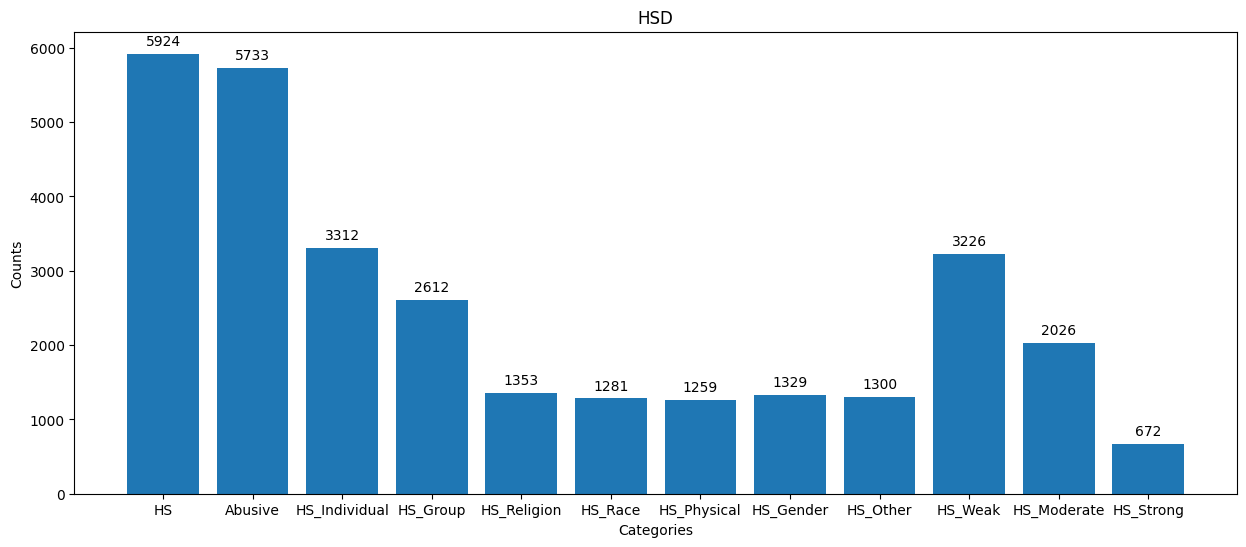

In [24]:
print("After:", data.shape)
label_columns = data.columns[1:]

aug_label_count = count_label_occurences(data, label_columns)
print(aug_label_count)

y = data[data.columns[1:]]
print(verify_imbalance_ratio(y))

plot_data(aug_label_count)

In [25]:
data = data.to_csv('./oversampled.csv', index=False)

In [10]:
data = pd.read_csv('./undersampled.csv', encoding='latin-1')

In [13]:
hs_mask = (
    (data['Abusive'] == 0) & 
    (data['HS'] == 0)
)   
hs = data[hs_mask]
hs_sampled = hs.sample(n=600, random_state=42)
print(hs.shape)
# hs_sampled = hs.sample(n=1440, random_state=42)
non_hs = data[~hs_mask]
data = pd.concat([non_hs, hs_sampled], axis=0).reset_index(drop=True)

(1440, 13)


In [14]:
print("After:", data.shape)

After: (2488, 13)


In [15]:
data.to_csv('./undersampled.csv', index=False, encoding='latin-1')

# OVERSAMPLE SEVERITY

Before: (13169, 13)
{'HS': 5561, 'Abusive': 5043, 'HS_Individual': 3575, 'HS_Group': 1986, 'HS_Religion': 793, 'HS_Race': 566, 'HS_Physical': 323, 'HS_Gender': 306, 'HS_Other': 3740, 'HS_Weak': 3383, 'HS_Moderate': 1705, 'HS_Strong': 473}
Imbalance ratios:
HS: 1.37
Abusive: 1.61
HS_Individual: 2.68
HS_Group: 5.63
HS_Religion: 15.61
HS_Race: 22.27
HS_Physical: 39.77
HS_Gender: 42.04
HS_Other: 2.52
HS_Weak: 2.89
HS_Moderate: 6.72
HS_Strong: 26.84
Mean imbalance ratio: 14.16
({'HS': 1.368099262722532, 'Abusive': 1.6113424548879636, 'HS_Individual': 2.6836363636363636, 'HS_Group': 5.6309164149043305, 'HS_Religion': 15.60655737704918, 'HS_Race': 22.266784452296818, 'HS_Physical': 39.77089783281734, 'HS_Gender': 42.0359477124183, 'HS_Other': 2.5211229946524063, 'HS_Weak': 2.892698788057937, 'HS_Moderate': 6.7237536656891495, 'HS_Strong': 26.841437632135307}, 14.162766245938968)


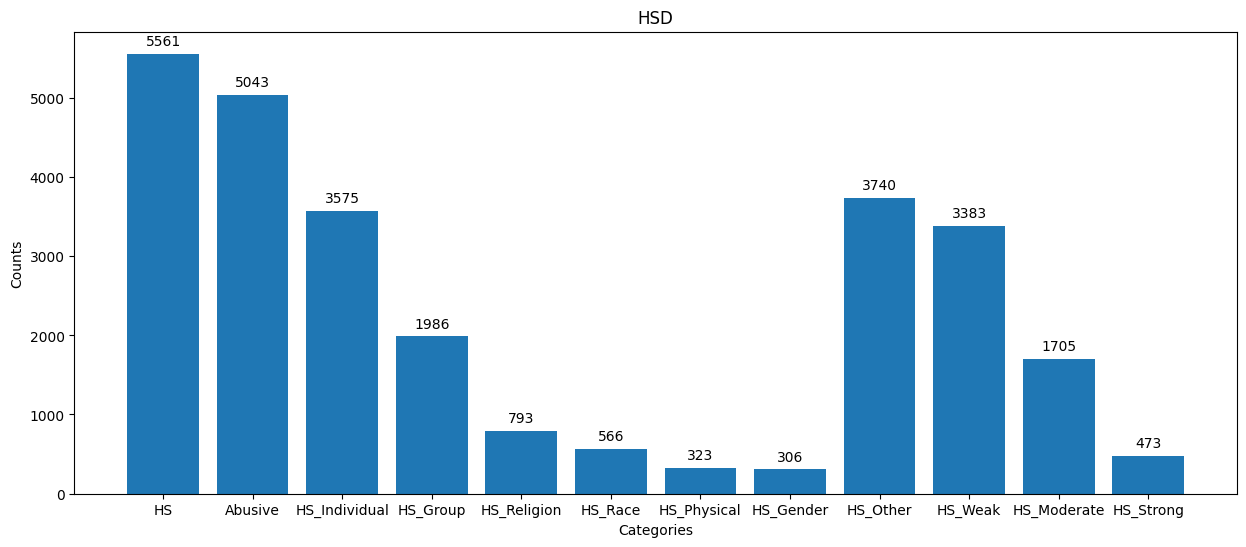

In [123]:
data = pd.read_csv('../re_dataset.csv', encoding='latin-1')
print("Before:", data.shape)

label_columns = data.columns[1:]
label_count = count_label_occurences(data, label_columns)
print(label_count)

y = data[label_columns]
print(verify_imbalance_ratio(y))

plot_data(label_count)

In [124]:
# Downsample HS_Other
other_weak_mask = (
    (data['HS_Other'] == 1) &
    (data['HS_Weak'] == 1)
)
other_weak = data[other_weak_mask]
print("Other:", other_weak.shape)
other_weak_sampled = other_weak.sample(n=387, random_state=42)
non_other_weak = data[~other_weak_mask]
data = pd.concat([non_other_weak, other_weak_sampled], axis=0).reset_index(drop=True)

Other: (2535, 13)


In [125]:
# Downsample HS_Other
other_moderate_mask = (
    (data['HS_Other'] == 1) &
    (data['HS_Moderate'] == 1)
)
other_moderate = data[other_moderate_mask]
print("Other:", other_moderate.shape)
other_moderate_sampled = other_moderate.sample(n=400, random_state=42)
non_other_moderate = data[~other_moderate_mask]
data = pd.concat([non_other_moderate, other_moderate_sampled], axis=0).reset_index(drop=True)

Other: (933, 13)


In [126]:
print("Augmenting HS_Gender with Weak Severity")
gender_weak = data[
    (data['HS_Gender'] == 1) & 
    (data['HS_Weak'] == 1)
]
print(gender_weak.shape)
translated = await back_translate_async(gender_weak["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    gender_weak["Tweet"].values[i] = translated[i]

Augmenting HS_Gender with Weak Severity
(243, 13)


In [127]:
print("Augmenting HS_Physical with Moderate Severity")
physical_moderate = data[
    (data['HS_Physical'] == 1) & 
    (data['HS_Group'] == 1) & 
    (data['HS_Moderate'] == 1)
]
print(physical_moderate.shape)
translated = await back_translate_async(physical_moderate["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    physical_moderate["Tweet"].values[i] = translated[i]

Augmenting HS_Physical with Moderate Severity
(42, 13)


In [128]:
print("Augmenting HS_Physical with Weak Severity")
physical = data[
    (data['HS_Physical'] == 1) & 
    (data['Abusive'] == 1) & 
    (data['HS_Weak'] == 1) &
    (data['HS_Individual'] == 1)
]
print(physical.shape)
translated = await back_translate_async(physical["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    physical["Tweet"].values[i] = translated[i]

Augmenting HS_Physical with Weak Severity
(274, 13)


In [129]:
print("Augmenting HS_Race with Strong Severity")
race_strong = data[(data['HS_Race'] == 1) & (data['HS_Group'] == 1) & (data['HS_Strong'] == 1)]
print(race_strong.shape)
translated = await back_translate_async(race_strong["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    race_strong["Tweet"].values[i] = translated[i]

Augmenting HS_Race with Strong Severity
(125, 13)


In [130]:
print("Augmenting HS_Race with Moderate Severity")
race = data[(data['HS_Race'] == 1) & (data['HS_Group'] == 1) & (data['HS_Moderate'] == 1)]
print(race.shape)
# race = race.sample(n=100, random_state=42)
translated = await back_translate_async(race["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    race["Tweet"].values[i] = translated[i]

Augmenting HS_Race with Moderate Severity
(288, 13)


In [131]:
# Augmenting HS_Religion
print("Augmenting HS_Religion with Moderate Severity")
religion = data[(data['HS_Religion'] == 1) & (data['HS_Group'] == 1) & (data['HS_Moderate'] == 1)]
religion = religion.sample(350, random_state=42)
print(religion.shape)
translated = await back_translate_async(religion["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    religion["Tweet"].values[i] = translated[i]

Augmenting HS_Religion with Moderate Severity
(350, 13)


In [132]:
print("Augmenting HS_Other with Strong Severity")
other_strong = data[
    (data['HS_Other'] == 1) & 
    (data['HS_Strong'] == 1) & 
    (data['HS_Individual'] == 1)
]
print(other_strong.shape)
translated = await back_translate_async(other_strong["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    other_strong["Tweet"].values[i] = translated[i]

Augmenting HS_Other with Strong Severity
(164, 13)


In [133]:
print("Augmenting Abusive")
abusive = data[
    (data['Abusive'] == 1) & 
    (data['HS'] == 0)
]
abusive = abusive.sample(n=476, random_state=42)
print(abusive.shape)
translated = await back_translate_async(abusive["Tweet"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    abusive["Tweet"].values[i] = translated[i]

Augmenting Abusive
(476, 13)


In [134]:
gen_weak = data[
    (data['HS_Gender'] == 1) & 
    (data['Abusive'] == 1) & 
    (data['HS_Weak'] == 1) &
    (data['HS_Individual'] == 1)
]

phys_mod = data[
    (data['HS_Physical'] == 1) & 
    (data['HS_Group'] == 1) & 
    (data['HS_Moderate'] == 1)
]

data = pd.concat([data, religion], axis=0).reset_index(drop=True)
data = pd.concat([data, race], axis=0).reset_index(drop=True)
data = pd.concat([data, physical], axis=0).reset_index(drop=True)
data = pd.concat([data, abusive], axis=0).reset_index(drop=True)

for i in range(3):
    if i < 2:
        data = pd.concat([data, gen_weak], axis=0).reset_index(drop=True)
        data = pd.concat([data, gender_weak], axis=0).reset_index(drop=True)
        data = pd.concat([data, other_strong], axis=0).reset_index(drop=True)
    data = pd.concat([data, race_strong], axis=0).reset_index(drop=True)

for i in range(8):
    if i < 7:
        data = pd.concat([data, phys_mod], axis=0).reset_index(drop=True)
    data = pd.concat([data, physical_moderate], axis=0).reset_index(drop=True)

After: (14169, 13)
{'HS': 6085, 'Abusive': 6085, 'HS_Individual': 2989, 'HS_Group': 3096, 'HS_Religion': 1390, 'HS_Race': 1288, 'HS_Physical': 1321, 'HS_Gender': 1335, 'HS_Other': 1387, 'HS_Weak': 2469, 'HS_Moderate': 2440, 'HS_Strong': 1176}
Imbalance ratios:
HS: 1.33
Abusive: 1.33
HS_Individual: 3.74
HS_Group: 3.58
HS_Religion: 9.19
HS_Race: 10.00
HS_Physical: 9.73
HS_Gender: 9.61
HS_Other: 9.22
HS_Weak: 4.74
HS_Moderate: 4.81
HS_Strong: 11.05
Mean imbalance ratio: 6.53
({'HS': 1.3285127362366476, 'Abusive': 1.3285127362366476, 'HS_Individual': 3.740381398461024, 'HS_Group': 3.576550387596899, 'HS_Religion': 9.193525179856115, 'HS_Race': 10.000776397515528, 'HS_Physical': 9.725965177895533, 'HS_Gender': 9.613483146067416, 'HS_Other': 9.215573179524153, 'HS_Weak': 4.738760631834751, 'HS_Moderate': 4.8069672131147545, 'HS_Strong': 11.048469387755102}, 6.526456464341215)


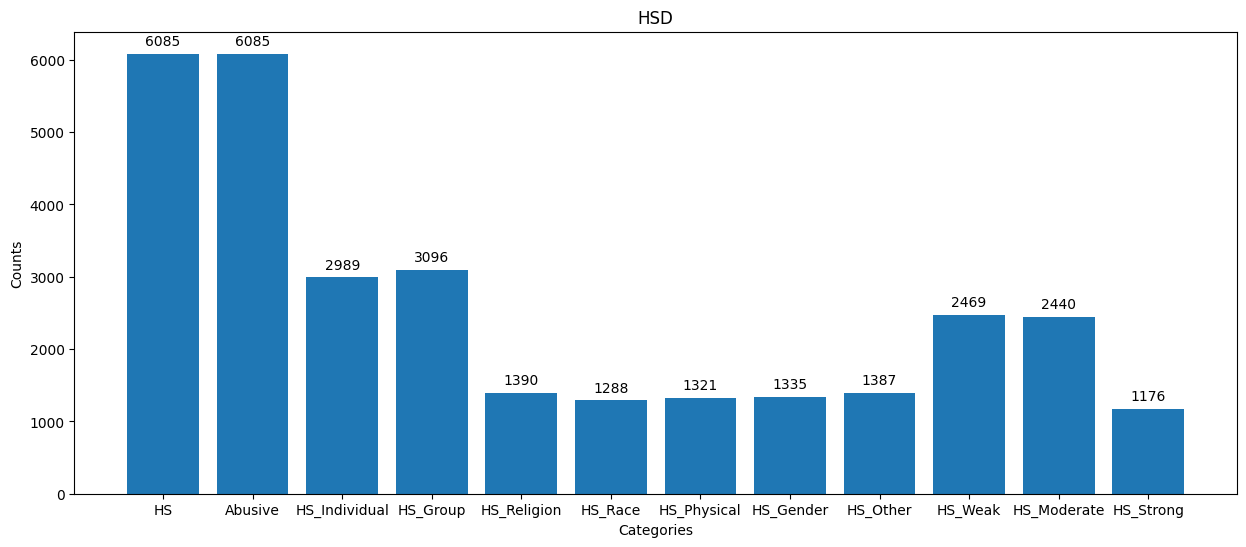

In [135]:
print("After:", data.shape)
label_columns = data.columns[1:]

aug_label_count = count_label_occurences(data, label_columns)
print(aug_label_count)

y = data[data.columns[1:]]
print(verify_imbalance_ratio(y))

plot_data(aug_label_count)

In [136]:
data.to_csv('./oversampled-2.csv', index=False)